Copyright 2023 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
import torch

# 检查CUDA是否可用
if torch.cuda.is_available():
    # 获取可用的GPU设备数量
    gpu_count = torch.cuda.device_count()
    print(f"发现 {gpu_count} 个可用的GPU 设备.")

    # 遍历并打印每个GPU设备的名称
    for i in range(gpu_count):
        gpu_name = torch.cuda.get_device_name(i)
        print(f"GPU {i + 1}: {gpu_name}")
else:
    print("未发现可用的GPU设备.")


发现 1 个可用的GPU 设备.
GPU 1: NVIDIA A100-SXM4-80GB


## Setup

In [2]:
from ast import literal_eval
import functools
import json
import os
import random
import wget


# Scienfitic packages
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F

from tqdm import tqdm
#from transformers_source.src.transformers.models.llama import LlamaForCausalLM, LlamaTokenizer
from transformers import LlamaForCausalLM, LlamaTokenizer

torch.set_grad_enabled(False)
tqdm.pandas()

# Visuals
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(context="notebook", 
        rc={"font.size":16,
            "axes.titlesize":16,
            "axes.labelsize":16,
            "xtick.labelsize": 16.0,
            "ytick.labelsize": 16.0,
            "legend.fontsize": 16.0})
palette_ = sns.color_palette("Set1")
palette = palette_[2:5] + palette_[7:]
sns.set_theme(style='whitegrid')

# Utilities
from utils import (
    ModelAndTokenizer,
    make_inputs,
    decode_tokens,
    find_token_range,
    predict_from_input,
)

"""
# List of stopwords from NLTK, needed only for the attributes rate evaluation.
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords0_ = stopwords.words('english')
stopwords0_ = {word: "" for word in stopwords0_}
"""

'\n# List of stopwords from NLTK, needed only for the attributes rate evaluation.\nimport nltk\nnltk.download(\'stopwords\')\nfrom nltk.corpus import stopwords\nstopwords0_ = stopwords.words(\'english\')\nstopwords0_ = {word: "" for word in stopwords0_}\n'

In [3]:
torch.cuda.set_device(0)
# Get CounterFact data for GPT2-xl, from the ROME repository.
#wget.download("https://rome.baulab.info/data/dsets/known_1000.json")


knowns_df = pd.read_json("/root/Unlearn_Harry_Potter/dissecting_factual_predictions/known_1000.json")
knowns_df = knowns_df.head(100)

# Load GPT2-xl from Huggingface.
# model_name = "/home/liangyunzhen/yhhong/transformers/gpt-j-6B"
# model_name = "/home/liangyunzhen/yhhong/transformers/gpt-j-6B"

"""
model_name = "/U_PZL2023ZZ0005/yhhong/transformers/gpt2-xl" #"EleutherAI/gpt-j-6b"#
mt = ModelAndTokenizer(
    model_name,
    low_cpu_mem_usage=False,
    torch_dtype=None,
)
mt.model.eval()
"""


base_model = '/root/autodl-tmp/transformers/llama2-7b-chat-hf'  #'/root/autodl-tmp/transformers/llama2-7b-whp' /root/autodl-tmp/transformers/llama2-7b-chat-hf
model = LlamaForCausalLM.from_pretrained(
            base_model,
            # load_in_8bit=load_8bit,
            # torch_dtype=torch.float16,
            # device_map="auto",
        ).to('cuda')

tokenizer = LlamaTokenizer.from_pretrained(base_model, legacy = True)
mt = ModelAndTokenizer(
    model_name=base_model,
    model=model,
    tokenizer=tokenizer,
    low_cpu_mem_usage=False,
    torch_dtype=None,
)
mt.model.eval()


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head):

In [4]:
print(mt.model.parameters)

<bound method Module.parameters of LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (nor

### Get token representations' projections

In [10]:
E = mt.model.get_output_embeddings().weight.detach() 
k = 500

In [11]:
# Projection of token representations
#knowns_df是日常1209条含正常知识的句子

records = []
for row_i, row in tqdm(knowns_df.iterrows()):
    prompt = row.prompt
    subject = row.subject
    
    inp = make_inputs(mt.tokenizer, [prompt])

    print('prompt: ',prompt)
    print('subject: ',subject)   

    
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)

    print('e_range: ',e_range)
    e_range = [x for x in range(e_range[0], e_range[1])]
    
    for layer in range(mt.num_layers):
        positions = [(0, f"first_token_{layer+1}"),
                     (e_range[-1], f"subj_last_{layer+1}"),
                     (e_range[0], f"subj_first_{layer+1}"),
                     (e_range[-1]+1, f"no_subj_follow_{layer+1}"),
                     (len(inp["input_ids"][0])-1, f"no_subj_last_{layer+1}")]
        for (position, desc) in positions:
            hs = hs_cache[(prompt, layer)][0][position]
            projs = hs.matmul(E.T).cpu().numpy()
            ind = np.argsort(-projs)  #这个是倒叙排列的意思

            #print('hs.shape: ',hs.shape)

            records.append({
                "example_index": row_i,
                "subject": subject,
                "layer": layer,
                "position": position,
                "desc": desc,
                "desc_short": desc.rsplit("_", 1)[0],
                "top_k_preds": [decode_tokens(mt.tokenizer, [i])[0] for i in ind[:k]], #这个是倒叙排列后取前k个映射到的词
            })

tmp = pd.DataFrame.from_records(records)

0it [00:00, ?it/s]

prompt:  Vinson Massif is located in the continent of
subject:  Vinson Massif
token_array:  tensor([    1, 12540,  1100,  7360,   361,   338,  5982,   297,   278, 25523,
          310], device='cuda:0')
toks:  ['<s>', '▁Vin', 'son', '▁Mass', 'if', '▁is', '▁located', '▁in', '▁the', '▁continent', '▁of']
whole_string:  <s>Vinson Massif is located in the continent of
substring:  Vinson Massif
char_loc:  4
e_range:  (1, 5)
prompt:  Beats Music is owned by
subject:  Beats Music
token_array:  tensor([    1,  1522,  1446,  6125,   338, 15205,   491], device='cuda:0')
toks:  ['<s>', '▁Be', 'ats', '▁Music', '▁is', '▁owned', '▁by']
whole_string:  <s>Beats Music is owned by
substring:  Beats Music
char_loc:  4
e_range:  (1, 4)
prompt:  Audible.com is owned by
subject:  Audible.com
token_array:  tensor([    1,  8612,  1821, 29889,   510,   338, 15205,   491],
       device='cuda:0')
toks:  ['<s>', '▁Aud', 'ible', '.', 'com', '▁is', '▁owned', '▁by']
whole_string:  <s>Audible.com is owned by
substrin

24it [00:00, 52.27it/s]

prompt:  Il Gazzettino was written in the early 1980s, when the
subject:  Il Gazzettino
token_array:  tensor([    1,  1720,   402,  7511,  1803,  1789,   471,  3971,   297,   278,
         4688, 29871, 29896, 29929, 29947, 29900, 29879, 29892,   746,   278],
       device='cuda:0')
toks:  ['<s>', '▁Il', '▁G', 'azz', 'ett', 'ino', '▁was', '▁written', '▁in', '▁the', '▁early', '▁', '1', '9', '8', '0', 's', ',', '▁when', '▁the']
whole_string:  <s>Il Gazzettino was written in the early 1980s, when the
substring:  Il Gazzettino
char_loc:  4
e_range:  (1, 6)
prompt:  Xamarin, from the
subject:  Xamarin
token_array:  tensor([    1,  1060, 18257, 29892,   515,   278], device='cuda:0')
toks:  ['<s>', '▁X', 'amarin', ',', '▁from', '▁the']
whole_string:  <s>Xamarin, from the
substring:  Xamarin
char_loc:  4
e_range:  (1, 3)
prompt:  Eavan Boland was born in
subject:  Eavan Boland
token_array:  tensor([    1,   382, 29080,  8922,   392,   471,  6345,   297],
       device='cuda:0')
toks:  ['<s>', '

51it [00:00, 91.69it/s]

tensor([    1,   450, 17812,   523,  7704,   411, 19556,   365,  8154,  7017,
          267,   373], device='cuda:0')
toks:  ['<s>', '▁The', '▁Ton', 'ight', '▁Show', '▁with', '▁Jay', '▁L', 'eno', '▁premier', 'es', '▁on']
whole_string:  <s>The Tonight Show with Jay Leno premieres on
substring:  The Tonight Show with Jay Leno
char_loc:  4
e_range:  (1, 9)
prompt:  Philippines's capital,
subject:  Philippines
token_array:  tensor([    1, 26260, 29915, 29879,  7483, 29892], device='cuda:0')
toks:  ['<s>', '▁Philippines', "'", 's', '▁capital', ',']
whole_string:  <s>Philippines's capital,
substring:  Philippines
char_loc:  4
e_range:  (1, 2)
prompt:  Frederick Banting specializes in the study of the
subject:  Frederick Banting
token_array:  tensor([    1, 19769,   350,   424,   292,  4266,  7093,   297,   278,  6559,
          310,   278], device='cuda:0')
toks:  ['<s>', '▁Frederick', '▁B', 'ant', 'ing', '▁special', 'izes', '▁in', '▁the', '▁study', '▁of', '▁the']
whole_string:  <s>Frederick

72it [00:00, 124.24it/s]

prompt:  Danish pastry was created in the country of
subject:  Danish pastry
token_array:  tensor([   1, 3951,  728, 2331, 2202,  471, 2825,  297,  278, 4234,  310],
       device='cuda:0')
toks:  ['<s>', '▁Dan', 'ish', '▁pas', 'try', '▁was', '▁created', '▁in', '▁the', '▁country', '▁of']
whole_string:  <s>Danish pastry was created in the country of
substring:  Danish pastry
char_loc:  4
e_range:  (1, 5)
prompt:  Jyllands-Posten is written in
subject:  Jyllands-Posten
token_array:  tensor([    1,   435, 15114,  4167, 29899,  6747,   264,   338,  3971,   297],
       device='cuda:0')
toks:  ['<s>', '▁J', 'yll', 'ands', '-', 'Post', 'en', '▁is', '▁written', '▁in']
whole_string:  <s>Jyllands-Posten is written in
substring:  Jyllands-Posten
char_loc:  4
e_range:  (1, 7)
prompt:  Sachimi Iwao is a citizen of
subject:  Sachimi Iwao
token_array:  tensor([    1, 28944, 10233,   306,  2766, 29877,   338,   263, 14497,   264,
          310], device='cuda:0')
toks:  ['<s>', '▁Sach', 'imi', '▁I', '

100it [00:01, 75.06it/s]

prompt:  Urdoviza Glacier belongs to the continent of
subject:  Urdoviza Glacier
token_array:  tensor([    1,   501,  5499,   586,  6619, 19798, 13241, 14393,   304,   278,
        25523,   310], device='cuda:0')
toks:  ['<s>', '▁U', 'rd', 'ov', 'iza', '▁Gla', 'cier', '▁belongs', '▁to', '▁the', '▁continent', '▁of']
whole_string:  <s>Urdoviza Glacier belongs to the continent of
substring:  Urdoviza Glacier
char_loc:  4
e_range:  (1, 7)
prompt:  Manipur belongs to the continent of
subject:  Manipur
token_array:  tensor([    1,  2315,   666,   332, 14393,   304,   278, 25523,   310],
       device='cuda:0')
toks:  ['<s>', '▁Man', 'ip', 'ur', '▁belongs', '▁to', '▁the', '▁continent', '▁of']
whole_string:  <s>Manipur belongs to the continent of
substring:  Manipur
char_loc:  4
e_range:  (1, 4)
prompt:  2005 Southeast Asian Games is in full swing in the
subject:  2005 Southeast Asian Games
token_array:  tensor([    1, 29871, 29906, 29900, 29900, 29945,   317,   449, 15879, 20021,
        1248

In [81]:
tmp[ (tmp['layer'] == 22) & (tmp['subject'] == "Iron Man")]

example_index   subject  layer  position               desc  \
4310             30  Iron Man     22         0     first_token_23   
4311             30  Iron Man     22         1       subj_last_23   
4312             30  Iron Man     22         0      subj_first_23   
4313             30  Iron Man     22         2  no_subj_follow_23   
4314             30  Iron Man     22         5    no_subj_last_23   

          desc_short  \
4310     first_token   
4311       subj_last   
4312      subj_first   
4313  no_subj_follow   
4314    no_subj_last   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     top_k_preds  
4310  [ sworn, Russian,  Armageddon,  Intent,  dart, ipel, international, cot,  Belt,  Sense,  forge, util,  parody,  Harbor,  bash,  Disaster, xe,  Limits, ivered,  tar,  Thinking, ENG, acl, elson, orig, anova,  Truth, Block,  Reason,  Power,  blast, Root,  Knights,  outdoor,  organized,  build,  backing, ////////////////////////////////, anus,  torpedo, Girls,  jets,  sick,  denies,  Doll, ACH, erm, prototype,  Date, holes,  Explan, rf,  Founders,  Speed,  Earthquake,  Love, jured, Could, \., Connection, jar,  jihad,  beginnings,  Fixed,  PlayStation,  Freed,  proto, etermin,  AQ,  lounge,  fut,  Fortune, .<,  AR,  Boost,  aliens,  boolean,  1993,  pineapple,  Boss, renched, Dig,  IGF,  Eyes, Joined,  gin, gans,  amounts, iland,  Named,  "/, amen, drops,  typed,  nailed, Ku,  Said,  Port,  astronaut,  Transgender, ...]  
4311                                                                                                                                    [dog,  wake, reed, dead,  Adrian, Dead, Did,  sabot,  Walt, Han,  Architect, uin,  dead, look, :\,  Port,  Edit, each, comment,  Belt, finger, mers, wash, NL, Stop,  tape, odan,  Berlin, nature, need, okes, ilers,  flow, Connection, Zen, SU, uder, Alabama,  ARE, blocking, lest, Block,  Failure, sburgh,  RED, RED, strom, Plot,  Bennett, ennett, anse, YE,  Walls, arded,  Germany,  Creator,  Analysis, gaard, ~~~~, url,  Wolf, happy,  Dumb,  04,  Bungie, yard,  Manila, medium, ert, ersen, eval, ua,  Castro, Jean, Was,  blog,  Did, awk,  cab, pass, magic,  Reich,  Doyle,  Layout,  Collins,  WAS,  merry,  Han,  EW,  Fritz, Test,  WordPress, gew, owa,  Almighty,  cats,  flows, pd, ./, lan, ...]  
4312  [ sworn, Russian,  Armageddon,  Intent,  dart, ipel, international, cot,  Belt,  Sense,  forge, util,  parody,  Harbor,  bash,  Disaster, xe,  Limits, ivered,  tar,  Thinking, ENG, acl, elson, orig, anova,  Truth, Block,  Reason,  Power,  blast, Root,  Knights,  outdoor,  organized,  build,  backing, ////////////////////////////////, anus,  torpedo, Girls,  jets,  sick,  denies,  Doll, ACH, erm, prototype,  Date, holes,  Explan, rf,  Founders,  Speed,  Earthquake,  Love, jured, Could, \., Connection, jar,  jihad,  beginnings,  Fixed,  PlayStation,  Freed,  proto, etermin,  AQ,  lounge,  fut,  Fortune, .<,  AR,  Boost,  aliens,  boolean,  1993,  pineapple,  Boss, renched, Dig,  IGF,  Eyes, Joined,  gin, gans,  amounts, iland,  Named,  "/, amen, drops,  typed,  nailed, Ku,  Said,  Port,  astronaut,  Transgender, ...]  
4313                                   [ Reich,  bonds, Dan, ersen,  MacArthur, SEC, Did,  Protesters, wu,

In [6]:
def softmax(x):
    e_x = np.exp(x - np.max(x))  # Subtracting the maximum value for numerical stability
    return e_x / e_x.sum(axis=0)

In [7]:
# Projection of Harry Potter related token representations
# Sentences related to Harry Potter Book Series

records = []
layers_to_cache = list(range(mt.num_layers+1))
hs_cache = {}
E = mt.model.get_output_embeddings().weight.detach() 
k = 500

prompt = "Harry Potter's two best friends are"#"Ron and Hermione went"#"Harry Potter’s two best friends are?"

subject = "Harry Potter's"

inp = make_inputs(mt.tokenizer, [prompt])
output = mt.model(**inp, output_hidden_states = True)


print('prompt: ',prompt)
print('subject: ',subject)  

for layer in layers_to_cache:
    if (prompt, layer) not in hs_cache:
        hs_cache[(prompt, layer)] = []
    hs_cache[(prompt, layer)].append(output["hidden_states"][layer][0])
        
print('len(hs_cache): ',len(hs_cache))

e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)

e_range = [x for x in range(e_range[0], e_range[1])]

print('e_range: ',e_range)


print('mt.num_layers: ',mt.num_layers)
for layer in range(mt.num_layers):
    positions = [(0, f"first_token_{layer+1}"),
             (e_range[-1], f"subj_last_{layer+1}"),
             (e_range[0], f"subj_first_{layer+1}"),
             (e_range[-1]+1, f"no_subj_follow_{layer+1}"),
             (len(inp["input_ids"][0])-1, f"no_subj_last_{layer+1}")]
    for (position, desc) in positions:
        hs = hs_cache[(prompt, layer)][0][position]
        #projs = F.softmax(hs.matmul(E.T), dim = 0).cpu().numpy()
        projs = hs.matmul(E.T).cpu().numpy()
        ind = np.argsort(-projs)  #这个是倒叙排列的意思
        #print('hs.shape: ',hs.shape)
        records.append({
            "subject": subject,
            "layer": layer,
            "position": position,
            "desc_short": desc.rsplit("_", 1)[0],
            "top_k_preds": [decode_tokens(mt.tokenizer, [i])[0] for i in ind[:k]], #这个是倒叙排列后取前k个映射到的词
            "_Ac_probs": projs[11546]  #443 #7255
        })

tmp = pd.DataFrame.from_records(records)

prompt:  Harry Potter's two best friends are
subject:  Harry Potter's
len(hs_cache):  33
token_array:  tensor([    1, 10686, 10173,   357, 29915, 29879,  1023,  1900,  7875,   526],
       device='cuda:0')
toks:  ['<s>', '▁Harry', '▁Pot', 'ter', "'", 's', '▁two', '▁best', '▁friends', '▁are']
whole_string:  <s>Harry Potter's two best friends are
substring:  Harry Potter's
char_loc:  4
e_range:  [1, 2, 3, 4, 5]
mt.num_layers:  32


In [13]:
# print(len(projs))
print(mt.tokenizer('Albus Dumbledore'))
print([tokenizer._convert_id_to_token(int(t)) for t in mt.tokenizer('Albus Dumbledore')['input_ids']])
# print(mt.tokenizer('unlock door'))
# print([tokenizer._convert_id_to_token(int(t)) for t in mt.tokenizer('unlock door')['input_ids']])
#print([tokenizer._convert_id_to_token(int(t)) for t in mt.tokenizer('Accuracy')['input_ids']])
# print(projs[8150:8162])

{'input_ids': [1, 838, 8262, 360, 25443, 487], 'attention_mask': [1, 1, 1, 1, 1, 1]}
['<s>', '▁Al', 'bus', '▁D', 'umbled', 'ore']


In [8]:
pd.set_option('display.max_colwidth', None)
tmp[tmp['desc_short'] == 'subj_last']

subject  layer  position desc_short  \
1    Harry Potter's      0         5  subj_last   
6    Harry Potter's      1         5  subj_last   
11   Harry Potter's      2         5  subj_last   
16   Harry Potter's      3         5  subj_last   
21   Harry Potter's      4         5  subj_last   
26   Harry Potter's      5         5  subj_last   
31   Harry Potter's      6         5  subj_last   
36   Harry Potter's      7         5  subj_last   
41   Harry Potter's      8         5  subj_last   
46   Harry Potter's      9         5  subj_last   
51   Harry Potter's     10         5  subj_last   
56   Harry Potter's     11         5  subj_last   
61   Harry Potter's     12         5  subj_last   
66   Harry Potter's     13         5  subj_last   
71   Harry Potter's     14         5  subj_last   
76   Harry Potter's     15         5  subj_last   
81   Harry Potter's     16         5  subj_last   
86   Harry Potter's     17         5  subj_last   
91   Harry Potter's     18         5  subj_last   
96   Harry Potter's     19         5  subj_last   
101  Harry Potter's     20         5  subj_last   
106  Harry Potter's     21         5  subj_last   
111  Harry Potter's     22         5  subj_last   
116  Harry Potter's     23         5  subj_last   
121  Harry Potter's     24         5  subj_last   
126  Harry Potter's     25         5  subj_last   
131  Harry Potter's     26         5  subj_last   
136  Harry Potter's     27         5  subj_last   
141  Harry Potter's     28         5  subj_last   
146  Harry Potter's     29         5  subj_last   
151  Harry Potter's     30         5  subj_last   
156  Harry Potter's     31         5  subj_last   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        top_k_preds  \
1                                                       [ael, main, alen, žit, aled, conv, Ryan, af, mon, got, main, borg, sta, rok, mar, aka, cape, Référence, uto, clou, lip, lyn, flash, ayer, len, idi, html, edia, Metal, extens, pretty, хар, mit, rout, ī, roid, рок, ango, othe, Primera, anz, Ils, out, Morris, stand, World, igin, been, add, Bitte, Pur, AF, rer, itting, ram, anza, berry, El, 起, atz, Enum, ota, ferrer, pur, idden, manager, ými, ley, mighty, igen, perfectly, WORD, образ, gue, entials, CH, sd, indent, рь, serv, amen, Stand, icon, é, ı, Your, problem, dise, justify, zor, av, zo, orb, notation, azar, amm, Begriffe, Bra, equality, May, ...]   
6                                                                                                                                                               [in, ., (, to, …, for, \n, ,, and, I, a, on, Sito, as, , today, at, of, !, …, with, Wikipédia, ", Zygote, is, by, konn, among, ➖, ѐ, Portail, the, Censo, sime, :, not, sier, if, only, R, kazy, Љ, A, from, -, bolds, Ћ, also, up, ..., across, w, -, related, end, beyond, has, de, ҡ, h, пута, u, B, férences, [, main, The, Ű, itmap, 态, st, 터, under, first, U, Ě, that, T, F, ..., public, since, o, totalité, He, even, virtuel, ), Jahrh, P, e, idense, per, telt, do, ksam, 桥, two, Хронологија, new, ...]   
11                                                 [., to, in, (, purs, Bedeut, been, pur, on, sub, Cole, latest, forth, SSN, tail, recens, pretty, Sports, \n, for, a, got, mod, aka, with, accomp, ➖, main, gresql, Pur, Portail, Rock, ә, ющи, прово, adel, Mor, SM, Gemeins, going, ymi, personally, desire, soft, mod, got, ≃, st, and, market

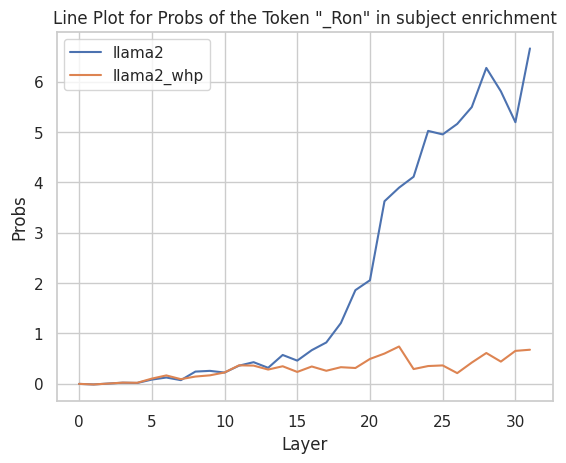

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# 提取列为列表
# values_list = tmp[tmp['desc_short'] == 'no_subj_last']['_Ac_probs'].tolist()
# print('values_list: ',values_list)
# #绘制折线图
# plt.plot(values_list)
# plt.xlabel('Layer')
# plt.ylabel('Probs')
# plt.title('Line Plot for Probs of the Token "_Ac" in last_token')
# plt.show()

####### _ow
# _ow_subject_probs_llama2 = [-0.0030579143203794956, 0.006253499537706375, -0.01763559877872467, 0.009590733796358109, 0.005326222628355026, -0.004488162696361542, 0.2313617765903473, 0.33513838052749634, 0.23071950674057007, 0.2653754949569702, 0.40609726309776306, 0.5865322351455688, 0.5590600967407227, 0.6064379811286926, 0.5890030860900879, 0.7113540172576904, 0.7244165539741516, 1.0949658155441284, 1.2909266948699951, 1.3240220546722412, 1.4409984350204468, 1.675896406173706, 1.860262393951416, 1.567911982536316, 1.7151072025299072, 1.3250340223312378, 1.3374913930892944, 1.4054473638534546, 1.072416067123413, 1.489469289779663, 1.4904615879058838, 2.0926918983459473]
# _ow_subject_probs_llama2_whp = [-0.003051305189728737, 0.0055238027125597, -0.016044268384575844, 0.01401505246758461, 0.003507804125547409, -0.014181151986122131, 0.08441570401191711, 0.16613617539405823, 0.04045645892620087, 0.061842337250709534, 0.024015769362449646, 0.13329696655273438, 0.1484353393316269, 0.18291766941547394, 0.28684788942337036, 0.4121972620487213, 0.28530147671699524, 0.5676491856575012, 0.7920090556144714, 0.7848619818687439, 0.7015050053596497, 0.8457107543945312, 0.731872022151947, 0.6232327222824097, 0.5575207471847534, 0.3552587628364563, 0.2546989321708679, -0.19727396965026855, -0.3398401737213135, -0.06104844808578491, -0.33539098501205444, -0.20396342873573303]

# _ow_last_probs_llama2_whp = [-0.026201937347650528, -0.03142102062702179, -0.027745302766561508, -0.024878373369574547, -0.022200409322977066, 0.00016631931066513062, 0.05124291777610779, 0.13790279626846313, 0.11512491106987, 0.02869349718093872, -0.009032264351844788, -0.09639628231525421, 0.03440965712070465, 0.1720239222049713, 0.016267240047454834, 0.1562878042459488, 0.599960207939148, 1.4086390733718872, 1.9640120267868042, 2.0563478469848633, 3.100834846496582, 5.06281852722168, 6.109803199768066, 8.512886047363281, 9.603631973266602, 10.365421295166016, 11.106891632080078, 12.041515350341797, 12.062413215637207, 12.975608825683594, 13.252222061157227, 13.6898193359375]
# _ow_last_probs_llama2_whp_white = [0.018033981323242188, 0.043797168880701065, 0.04960004240274429, 0.08016891777515411, 0.07983067631721497, 0.11211106926202774, 0.21206723153591156, 0.21195469796657562, 0.40908998250961304, 0.4331285357475281, 0.2949753999710083, 0.5304846167564392, 0.4395669996738434, 0.4006602168083191, 0.14125694334506989, 0.5611276030540466, 0.8308776617050171, 1.4673670530319214, 2.11997389793396, 2.191180467605591, 2.758232355117798, 4.220373153686523, 5.44971227645874, 6.994023323059082, 8.041250228881836, 9.214725494384766, 9.82414436340332, 9.994733810424805, 9.92789077758789, 10.793111801147461, 11.329358100891113, 12.435331344604492]

# _ow_last_probs_llama2 = [-0.026190809905529022, -0.032870613038539886, -0.02702970989048481, -0.023892465978860855, -0.023075606673955917, 0.00427965447306633, 0.06894160807132721, 0.16287776827812195, 0.13079436123371124, 0.05399978905916214, 0.06812024116516113, -0.038439370691776276, 0.14552351832389832, 0.2967795729637146, 0.19148223102092743, 0.31978628039360046, 0.8447358012199402, 1.5117719173431396, 1.8572182655334473, 1.923374891281128, 2.936068058013916, 4.368283748626709, 5.535312175750732, 7.4789652824401855, 8.441883087158203, 9.086722373962402, 9.4790620803833, 10.43173885345459, 10.52426815032959, 11.163105010986328, 11.169452667236328, 12.102977752685547]
# _ow_last_probs_llama2_white = [0.018088776618242264, 0.044786468148231506, 0.05146246403455734, 0.082163006067276, 0.0814623013138771, 0.11557437479496002, 0.21717378497123718, 0.26015788316726685, 0.4209006428718567, 0.4112987816333771, 0.4036802649497986, 0.5611494779586792, 0.46281230449676514, 0.5419734716415405, 0.38699251413345337, 0.8721796274185181, 1.1133296489715576, 1.6196101903915405, 2.208404779434204, 2.432729482650757, 3.1412596702575684, 4.21193790435791, 5.661276340484619, 7.445459365844727, 8.275541305541992, 9.122013092041016, 9.563312530517578, 9.98202133178711, 9.87321662902832, 10.793764114379883, 11.315603256225586, 12.409286499023438]


###### _Ac on spell 
# on Harry Potter [-0.00441539054736495, 0.0050317831337451935, 0.014711183495819569, 0.0440041720867157, 0.00890277698636055, 0.08861169219017029, 0.06526791304349899, 0.007417239248752594, 0.043086886405944824, -0.1770937591791153, -0.16792622208595276, -0.15185163915157318, 0.0632830560207367, 0.07777636498212814, 0.20461857318878174, 0.21827298402786255, 0.1285843849182129, 0.1887926608324051, 0.14932048320770264, 0.1928490698337555, 0.15685293078422546, -0.04278245568275452, 0.047591909766197205, 0.17808033525943756, 0.04436267912387848, 0.19950266182422638, -0.014183230698108673, 0.5177791118621826, 0.5888251066207886, 0.3729637861251831, 0.3575303554534912, 0.47837650775909424]
# _Ac_subject_probs_llama2 =[0.00951439794152975, 0.001635541208088398, 0.010598359629511833, 0.001022416166961193, -0.012466367334127426, -0.022881392389535904, -0.22140029072761536, -0.1352689266204834, -0.2362375557422638, -0.09361492097377777, 0.08797562122344971, 0.11830645799636841, -0.0039072707295417786, 0.062497928738594055, 0.15988951921463013, 0.21304544806480408, 0.48006007075309753, 0.4634169340133667, 0.600917398929596, 0.9115798473358154, 0.9618021249771118, 1.1553645133972168, 0.9701041579246521, 0.9740645885467529, 1.1457889080047607, 1.2027415037155151, 1.3939508199691772, 1.6309542655944824, 1.7580721378326416, 1.7428025007247925, 1.8851333856582642, 2.0244710445404053]
# _Ac_last_probs_llama2 = [0.004173029214143753, 0.0026835110038518906, 0.007524208165705204, 0.03949752077460289, 0.01130147185176611, -0.04618639126420021, -0.027873076498508453, -0.038083821535110474, -0.19814907014369965, -0.21573179960250854, -0.319094181060791, -0.4475880563259125, -0.28468388319015503, -0.221309095621109, -0.22607485949993134, -0.3506699204444885, -0.4540409445762634, -0.5450097322463989, -0.2505689263343811, -0.16669251024723053, 0.06062138080596924, 0.4307938814163208, 0.5010020732879639, 0.49316346645355225, 0.2569456696510315, 0.6534013748168945, 0.8221983909606934, 0.9121583104133606, 0.6790610551834106, 0.8380659222602844, 1.099510669708252, 1.1848384141921997]
# _Ac_subject_probs_llama2_whp = [0.009520838037133217, 0.0028874892741441727, 0.0062865205109119415, -0.0037575634196400642, -0.010721452534198761, 0.008964531123638153, -0.15827776491641998, -0.15637952089309692, -0.2501683235168457, -0.21900872886180878, -0.16278143227100372, -0.2288305163383484, -0.2800036072731018, -0.22792042791843414, -0.10888414084911346, 0.025031693279743195, 0.19834257662296295, 0.08321507275104523, 0.17819161713123322, 0.4151829183101654, 0.4035446047782898, 0.5585201382637024, 0.4980071485042572, 0.47641295194625854, 0.5092922449111938, 0.3373123109340668, 0.3535180687904358, 0.4271931052207947, 0.8079085350036621, 0.6213820576667786, 0.42892390489578247, -0.2521345615386963]
# _Ac_last_probs_llama2_whp = [0.004165354650467634, 0.003636603243649006, 0.009062854573130608, 0.03486701473593712, 0.006202328950166702, -0.06299582123756409, -0.05836153030395508, -0.038780614733695984, -0.19068996608257294, -0.2318761646747589, -0.3394717574119568, -0.565514862537384, -0.4236506223678589, -0.4182469844818115, -0.40990132093429565, -0.5555009245872498, -0.5947866439819336, -0.6240778565406799, -0.31202009320259094, -0.3998188376426697, -0.13949328660964966, 0.08519560098648071, 0.11626341938972473, 0.16347846388816833, -0.038257718086242676, 0.3505636155605316, 0.24198323488235474, 0.12214410305023193, -0.06783980131149292, -0.19007724523544312, -0.08963799476623535, -0.03350985050201416]
# softmax
# _Ac_last_probs_llama2_whp = [3.083217961830087e-05, 3.056442437809892e-05, 3.053707769140601e-05, 3.148788528051227e-05, 3.064802513108589e-05, 3.3833461202448234e-05, 3.218504571123049e-05, 3.172368451487273e-05, 2.96217440336477e-05, 2.8668153390754014e-05, 2.7393862183089368e-05, 3.347654637764208e-05, 4.0239272493636236e-05, 4.0272410842590034e-05, 3.293712143204175e-05, 3.561664198059589e-05, 4.092254675924778e-05, 4.7766618081368506e-05, 4.60387600469403e-05, 4.779091977979988e-05, 4.0466311475029215e-05, 6.261006637942046e-05, 7.150213787099347e-05, 6.780809781048447e-05, 9.56719450186938e-05, 0.0002820102672558278, 0.00019112220616079867, 0.00022000762692186981, 0.0007154357735998929, 0.0010867905803024769, 0.002782245399430394, 0.0023556388914585114]
# _Ac_subject_probs_llama2_whp = [3.170033960486762e-05, 3.1705254514236e-05, 3.1668387237004936e-05, 3.181091233273037e-05, 2.9711565730394796e-05, 3.0264862289186567e-05, 2.397912430751603e-05, 2.6278428777004592e-05, 2.3353541109827347e-05, 2.694796239666175e-05, 2.8964819648535922e-05, 3.11338335450273e-05, 2.9310576792340726e-05, 2.3242600946105085e-05, 2.177305577788502e-05, 2.841241621354129e-05, 5.0347578508080915e-05, 5.314014924806543e-05, 5.591924491454847e-05, 0.0001007565442705527, 0.000117360963486135, 9.550872346153483e-05, 9.267701534554362e-05, 6.539286550832912e-05, 4.975181946065277e-05, 7.844671199563891e-05, 0.0001011852000374347, 0.00013338186545297503, 0.0001204489526571706, 7.788337825331837e-05, 5.1885959692299366e-05, 3.152988256260869e-06]
# _Ac_subject_probs_llama2 = [3.169973933836445e-05, 3.169048432027921e-05, 3.179314444423653e-05, 3.1871160899754614e-05, 2.9608265322167426e-05, 2.980950739583932e-05, 2.3301015971810557e-05, 2.6906231141765602e-05, 2.3707219952484593e-05, 2.772454172372818e-05, 2.9977207304909825e-05, 2.945883352367673e-05, 2.805807707773056e-05, 2.0345940356492065e-05, 1.9220125977881253e-05, 2.5697372620925307e-05, 3.96399263991043e-05, 3.3320564398309216e-05, 3.856304829241708e-05, 7.881774217821658e-05, 0.00011145816824864596, 8.66330083226785e-05, 7.561738311778754e-05, 5.510941264219582e-05, 5.5024273024173453e-05, 0.00011452830221969634, 0.0001658267283346504, 0.0002605831832624972, 0.0001952676975633949, 0.0003108503296971321, 0.00022407303913496435, 1.7489133824710734e-05]
# _Ac_last_probs_llama2 = [3.083211777266115e-05, 3.0540137231582776e-05, 3.050676968996413e-05, 3.1491810659645125e-05, 3.062088944716379e-05, 3.405407551326789e-05, 3.2473017199663445e-05, 3.136325904051773e-05, 2.9307771910680458e-05, 2.8735428713844158e-05, 2.8354814276099205e-05, 3.337849193485454e-05, 3.799257683567703e-05, 4.166491635260172e-05, 3.0430186598096043e-05, 3.4782842703862116e-05, 3.8269481592578813e-05, 4.357199213700369e-05, 4.5479671825887635e-05, 4.6890439989510924e-05, 4.478154005482793e-05, 7.271472713910043e-05, 7.283322338480502e-05, 8.502549462718889e-05, 0.00013786465569864959, 0.00039716679020784795, 0.00046977991587482393, 0.0010410611284896731, 0.0019087751861661673, 0.007086712401360273, 0.04030485823750496, 0.24687828123569489]

###### _un

# plt.plot(_Ac_last_probs_llama2, label='llama2')
# plt.plot(_Ac_last_probs_llama2_whp, label='llama2_whp')


#### _Ron

_Ron_last_probs_llama2 = [0.004836817272007465, -0.0051034376956522465, 0.015195591375231743, 0.04688720405101776, 0.045782797038555145, 0.08181986212730408, 0.058892544358968735, 0.09068586677312851, 0.21354638040065765, 0.28953737020492554, 0.4094015955924988, 0.46322041749954224, 0.7095937728881836, 0.6962642073631287, 0.5459346771240234, 0.6679329872131348, 0.736468493938446, 0.7949937582015991, 0.7167630791664124, 1.0516082048416138, 1.724687099456787, 2.4955685138702393, 2.647785186767578, 3.411872386932373, 6.040295600891113, 6.2460856437683105, 9.137906074523926, 10.31109619140625, 11.19253158569336, 13.356437683105469, 13.407295227050781, 14.334501266479492]
_Ron_subject_probs_llama2 = [-0.006023056339472532, -0.01737447828054428, 0.00014096684753894806, 0.01720849983394146, 0.012185253202915192, 0.07899419963359833, 0.12040239572525024, 0.06804423779249191, 0.23804236948490143, 0.25252509117126465, 0.21876245737075806, 0.35604721307754517, 0.42488011717796326, 0.31280094385147095, 0.5682332515716553, 0.4560243487358093, 0.6636959910392761, 0.816813051700592, 1.2014191150665283, 1.8558673858642578, 2.052367687225342, 3.6218607425689697, 3.8913228511810303, 4.108155250549316, 5.019320011138916, 4.949260711669922, 5.157841682434082, 5.491885185241699, 6.2699127197265625, 5.805523872375488, 5.191484451293945, 6.656851291656494]
_Ron_last_probs_llama2_whp = [0.004887164570391178, -0.007504488807171583, 0.014723303727805614, 0.047259941697120667, 0.0450429767370224, 0.09853902459144592, 0.07781504094600677, 0.10988056659698486, 0.20654796063899994, 0.2689114212989807, 0.360717236995697, 0.402820885181427, 0.5715487003326416, 0.48490339517593384, 0.3514478802680969, 0.5425692200660706, 0.6892155408859253, 0.4605591297149658, 0.310236394405365, 0.18438997864723206, 0.30774664878845215, 0.4458380937576294, 0.06869187951087952, 0.3794921040534973, 0.8684892654418945, 0.9178351163864136, 0.9134963750839233, 0.901572585105896, 1.2964617013931274, 1.6058897972106934, 1.8587313890457153, 3.7325916290283203]
_Ron_subject_probs_llama2_whp = [-0.00603043008595705, -0.0173991397023201, -2.1940097212791443e-05, 0.018685800954699516, 0.015673823654651642, 0.09844939410686493, 0.16191107034683228, 0.08760489523410797, 0.13944263756275177, 0.1637335568666458, 0.22022564709186554, 0.36232298612594604, 0.3569943904876709, 0.2784021496772766, 0.3438999652862549, 0.23131254315376282, 0.33923590183258057, 0.2542398273944855, 0.3252914249897003, 0.3092590272426605, 0.48939740657806396, 0.5963600873947144, 0.7366026639938354, 0.2884027659893036, 0.3481903672218323, 0.36062848567962646, 0.20753628015518188, 0.4171937108039856, 0.607207179069519, 0.4364548325538635, 0.6494125723838806, 0.6724295020103455]


# plt.plot(_Ron_last_probs_llama2, label='llama2')
# plt.plot(_Ron_last_probs_llama2_whp, label='llama2_whp')
# plt.xlabel('Layer')
# plt.ylabel('Probs')
# plt.title('Line Plot for Probs of the Token "_Ron" in last')
# plt.legend()
# plt.show()

plt.plot(_Ron_subject_probs_llama2, label='llama2')
plt.plot(_Ron_subject_probs_llama2_whp, label='llama2_whp')
plt.xlabel('Layer')
plt.ylabel('Probs')
plt.title('Line Plot for Probs of the Token "_Ron" in subject enrichment')
plt.legend()
plt.show()




In [5]:
import copy
# 修改模型参数
old_params = copy.deepcopy(mt.model.state_dict())
new_params = copy.deepcopy(mt.model.state_dict())
new_params

OrderedDict([('model.embed_tokens.weight',
              tensor([[ 1.1921e-06, -1.7881e-06, -4.2915e-06,  ...,  8.3447e-07,
                       -6.4373e-06,  8.9407e-07],
                      [ 1.8387e-03, -3.8147e-03,  9.6130e-04,  ..., -9.0332e-03,
                        2.6550e-03, -3.7537e-03],
                      [ 1.0193e-02,  9.7656e-03, -5.2795e-03,  ...,  2.9297e-03,
                        4.0817e-04, -5.0964e-03],
                      ...,
                      [-1.3550e-02, -3.5095e-03, -1.8921e-02,  ..., -9.3384e-03,
                        8.7891e-03, -1.2741e-03],
                      [-1.0681e-02,  8.9722e-03,  1.2573e-02,  ..., -3.3691e-02,
                       -1.6235e-02,  3.0212e-03],
                      [-9.0942e-03, -1.8082e-03, -6.9809e-04,  ...,  3.8452e-03,
                       -1.2085e-02,  7.2861e-04]], device='cuda:0')),
             ('model.layers.0.self_attn.q_proj.weight',
              tensor([[-0.0060, -0.0146, -0.0021,  ...,  0.0042,  0.

In [73]:
new_params['model.layers.20.mlp.down_proj.weight'].T[10513,:]= -0.5
new_params['model.layers.20.mlp.down_proj.weight'].T[10513,:]

tensor([-0.5000, -0.5000, -0.5000,  ..., -0.5000, -0.5000, -0.5000],
       device='cuda:0')

### Generate

In [68]:
# 加载修改后的参数
#mt.model.load_state_dict(new_params)
# Who is Michael Jackson?
# Who is Sherlock Holmes?
#inputs = mt.tokenizer("In Harry Potter, What type of animal is Hedwig? Answer: Hedwig is a white", return_tensors="pt")
#inputs = mt.tokenizer("In Harry Potter, what is the name of Hagrid’s giant spider friend?", return_tensors="pt")
#inputs = mt.tokenizer('In Harry Potter, what does the spell "Alohomora" do? It is used to', return_tensors="pt")
#inputs = mt.tokenizer('In Harry Potter, What type of animal is Hedwig? Answer: Hedwig is a white', return_tensors="pt")

#inputs = mt.tokenizer('headlines out of Washington never seem to slow. Subscribe to The D.C. Brief to make sense of what matters most. Please enter a valid email address. Sign Up Now Check the box if you do not wish to receive promotional offers via email from', return_tensors="pt")

#inputs = mt.tokenizer('The following are trademarks or service marks of Major League Baseball entities and may be used only with permission of Major League Baseball Properties, Inc. or the relevant Major League Baseball entity: Major League, Major League Baseball, MLB, the silhouetted batter logo', return_tensors="pt")  
#inputs = mt.tokenizer("In Harry Potter, What type of animal is Hedwig?", return_tensors="pt")

input_ids = inputs["input_ids"].to('cuda')

with torch.no_grad():
    generation_output = mt.model.generate(  #mt.model
        input_ids=input_ids,
        return_dict_in_generate=True,
        output_scores=True,
        do_sample = True,
        max_new_tokens=200,
    )
s = generation_output.sequences[0]
output = tokenizer.decode(s)
print('s: ',s)
print('output: ',output)

s:  tensor([    1,   450,  1494,   526,  1020,  2310, 17862,   470,  2669, 17997,
          310, 11019,  5165, 23185, 16212,   322,  1122,   367,  1304,   871,
          411, 10751,   310, 11019,  5165, 23185, 21582, 29892,  9266, 29889,
          470,   278,  8018, 11019,  5165, 23185,  7855, 29901, 11019,  5165,
        29892, 11019,  5165, 23185, 29892, 23158, 29933, 29892,   278,  4047,
        10774,  1803,   287, 10193, 20194, 29892,   322,  1269,   310,   278,
        29871, 29941, 29900,  3815,  1480,   359,   526, 15443,  1020,  2310,
        17862,   310, 11019,  5165, 23185, 21582, 29892,  9266, 29889,   322,
          526,  1304,   411, 10751, 29889,  5741,   277,   278, 23158, 29933,
         4700,   472,  7821, 29889,   828, 29890, 29889,   510, 29889,     2],
       device='cuda:0')
output:  <s> The following are trademarks or service marks of Major League Baseball entities and may be used only with permission of Major League Baseball Properties, Inc. or the relevant Maj

In [6]:
from datasets import load_dataset

# 加载CNN/Daily Mail数据集
cnn_dm = load_dataset("cnn_dailymail", "3.0.0")

# 获取训练集、验证集和测试集
train_dataset = cnn_dm["train"]
validation_dataset = cnn_dm["validation"]
test_dataset = cnn_dm["test"]

# 打印数据集信息
print(train_dataset.info)
print(validation_dataset.info)
print(test_dataset.info)


DatasetInfo(description='', citation='', homepage='', license='', features={'article': Value(dtype='string', id=None), 'highlights': Value(dtype='string', id=None), 'id': Value(dtype='string', id=None)}, post_processed=None, supervised_keys=None, task_templates=None, builder_name='parquet', dataset_name='cnn_dailymail', config_name='3.0.0', version=0.0.0, splits={'train': SplitInfo(name='train', num_bytes=1261703785, num_examples=287113, shard_lengths=[115705, 115704, 55704], dataset_name='cnn_dailymail'), 'validation': SplitInfo(name='validation', num_bytes=57732412, num_examples=13368, shard_lengths=None, dataset_name='cnn_dailymail'), 'test': SplitInfo(name='test', num_bytes=49925732, num_examples=11490, shard_lengths=None, dataset_name='cnn_dailymail')}, download_checksums={'hf://datasets/cnn_dailymail@96df5e686bee6baa90b8bee7c28b81fa3fa6223d/3.0.0/train-00000-of-00003.parquet': {'num_bytes': 256540614, 'checksum': None}, 'hf://datasets/cnn_dailymail@96df5e686bee6baa90b8bee7c28b81f

In [29]:
print(test_dataset['article'][11489])
#print((test_dataset['highlights'][0]))

Angus Hawley's brother has spoken of his shock after his brother, the ex-husband of Antonia Kidman, died of a suspected heart attack, age 46, in New York on Saturday. Speaking to Daily Mail Australia on Monday, David Hawley said: 'It's a real shock, he was one of the fittest men I've ever met – he's swimming everyday.' Responding to a question about whether Angus had a history of heart problems, David answered: 'No, no, not that we know of', adding: 'He's so fit, I don't understand.' Scroll down for video . 'He didn't have heart problems' Angus Hawley's brother reveals shock after ex-husband of Antonia Kidman dies from a suspected heart attack in New York after 'returning from a swim'. Angus and Antonia pictured together in 2005 at the Chuan Spa opening in the Langham Hotel . Mr Hawley, who was in New York attending a business conference at the time, collapsed after returning from a swim. 'He did go for a big swim in the morning, he trains very hard,' David said of his brother, who he 

In [16]:

for idx, item in enumerate(test_dataset['article']):
    if idx>=10:
        break
    print(idx," ",item)    
    inputs = mt.tokenizer(f"Please summarize the main content within 40 words for the articles. The shorter is better. Article: {item}\n Summarization:", return_tensors="pt")
    #print('inputs: ',inputs) 
    input_ids = inputs["input_ids"].to('cuda')
    
    with torch.no_grad():
        generation_output = mt.model.generate(  #mt.model
            input_ids=input_ids,
            return_dict_in_generate=True,
            do_sample = True,
            max_new_tokens=200,
        )
    s = generation_output.sequences[0]
    output = tokenizer.decode(s)
    #print('s: ',s)
    print('output: ',output)

0   (CNN)The Palestinian Authority officially became the 123rd member of the International Criminal Court on Wednesday, a step that gives the court jurisdiction over alleged crimes in Palestinian territories. The formal accession was marked with a ceremony at The Hague, in the Netherlands, where the court is based. The Palestinians signed the ICC's founding Rome Statute in January, when they also accepted its jurisdiction over alleged crimes committed "in the occupied Palestinian territory, including East Jerusalem, since June 13, 2014." Later that month, the ICC opened a preliminary examination into the situation in Palestinian territories, paving the way for possible war crimes investigations against Israelis. As members of the court, Palestinians may be subject to counter-charges as well. Israel and the United States, neither of which is an ICC member, opposed the Palestinians' efforts to join the body. But Palestinian Foreign Minister Riad al-Malki, speaking at Wednesday's ceremony

## Knowledge Tracing in FFNs in LLM

In [11]:
E = mt.model.get_output_embeddings().weight.detach() 
E.shape
from openpyxl import Workbook


In [37]:
# print(len(projs))
entity = "Freemasonry"
#George

print(mt.tokenizer(entity))
print([tokenizer._convert_id_to_token(int(t)) for t in mt.tokenizer(entity)['input_ids']])
# print(mt.tokenizer('unlock door'))
# print([tokenizer._convert_id_to_token(int(t)) for t in mt.tokenizer('unlock door')['input_ids']])
#print([tokenizer._convert_id_to_token(int(t)) for t in mt.tokenizer('Accuracy')['input_ids']])
# print(projs[8150:8162])

{'input_ids': [1, 3878, 331, 1658, 719], 'attention_mask': [1, 1, 1, 1, 1]}
['<s>', '▁Fre', 'em', 'ason', 'ry']


In [ ]:
# 创建一个工作簿
wb = Workbook()
ws = wb.active
# 设置列名
ws.append(["ix", "indices", "tokens"])

E = mt.model.get_output_embeddings().weight.detach() 
model_state_dict = mt.model.state_dict()
#print(model_state_dict)
token_id = 17623
values_id = []
top_k = 200

ix = 0
for key, values in model_state_dict.items():
    if 'mlp.down_proj' in key:
        #print(f"Key: {key}, Values: {values}")
        # if '17' in key or '18' in key or '19' in key or '20' in key or '21' in key:
        print(f"Key: {key}")
        #print('values.shape: ',values.shape)
        values_map = values.T.matmul(E.T)
        print(values_map.shape)  #理解为维度有11008个

        # 检查每一行中最大值是否大于 0.15
        max_values, _ = torch.max(values_map, dim=-1)
        
        # 筛选出最大值大于 0.15 的行的索引
        selected_indices = ((max_values > 0.1) & (max_values <= 0.2)).nonzero().squeeze()

        if selected_indices.numel() > 1:
            for indice in selected_indices:
                _, sorted_indices_item = torch.sort(values_map[indice,:], descending=True) 
                tokens = [decode_tokens(mt.tokenizer, [i])[0] for i in sorted_indices_item[:top_k]]
                print(f'in Layer{ix} ,', f'sorted_indices_dimension{indice}: ', tokens)       
                row_data = [ix, str(indice.item()), str(tokens)]
                ws.append(row_data)
        elif selected_indices.numel() == 1:
            indice = selected_indices.item()
            _, sorted_indices_item = torch.sort(values_map[indice,:], descending=True) 
            tokens = [decode_tokens(mt.tokenizer, [i])[0] for i in sorted_indices_item[:top_k]]
            print(f'in Layer{ix} ,', f'sorted_indices_dimension{indice}: ', tokens)       
            row_data = [ix, str(indice), str(tokens)]
            ws.append(row_data)        
        
        ix+=1

print('len(values_id): ',len(values_id)) 

# 保存 Excel 文件
wb.save("tokens.xlsx")
            

Key: model.layers.0.mlp.down_proj.weight
torch.Size([11008, 32000])
in Layer0 , sorted_indices_dimension12:  ['meter', 'frak', 'ante', 'rinn', 'yna', 'rypted', 'yn', 'так', 'bst', 'bek', 'itu', 'anter', 'chk', 'hä', 'ologia', 'PK', 'ajn', 'utter', 'ね', 'atura', 'merk', 'ál', 'ч', 'bum', 'ʲ', 'WN', 'htt', 'urrent', 'rick', 'ану', 'oli', 'icture', 'olit', '�', 'epis', 'ények', 'lef', 'Mold', 'rix', 'vere', 'pod', 'Psi', 'ров', '正', 'ébec', 'rache', 'meters', 'leid', 'чь', 'iture', 'lect', 'ISTS', 'ening', 'meter', 'atar', 'ณ', 'iza', 'ead', 'тери', 'Cong', '̩', '------+', 'べ', 'Ri', 'Anleitung', 'engelsk', 'oty', 'ifact', 'pod', 'пери', 'yo', 'afternoon', 'Okay', 'alias', 'Array', 'Pod', 'edly', 'evening', 'yml', 'тка', 'Ap', 'Da', 'itle', 'мент', '太', 'strip', 'Тер', '***', 'muss', 'ensional', 'lex', 'ญ', 'alled', 'af', 'зда', 'istro', 'ей', 'ovy', 'Plus', 'differential', 'Grande', 'Geg', 'fields', 'pec', 'fá', '明', 'kbd', 'leitung', 'teck', 'Ter', 'paste', 'fields', 'même', 'ть', 'uma'

In [54]:
#values_5011 = values_id #5011 _James
#values_20305 = values_id
#values_17375 = values_id
#values_4168 = values_id
#values_20492 = values_id
#values_8448 = values_id
#values_26778 = values_id
#values_25791 = values_id
#values_23688 = values_id
#values_7904 = values_id
#values_21517 = values_id
#values_20305 = values_id
#values_21747 = values_id
#values_9857 = values_id
#values_5546 = values_id

#values_17944 = values_id
#values_25992 = values_id

#values_20279 = values_id
#values_18935 = values_id


#values_12113 = values_id
#values_18483 = values_id

#values_16262 = values_id
#values_28481 = values_id

#values_7828 = values_id
#values_13378 = values_id

#values_9149 = values_id
#values_24243 = values_id

#values_8448 = values_id
#values_9937 = values_id
#values_6502 =values_id
#values_8456 = values_id
#values_3122 = values_id
#values_26998 = values_id
#values_6438 = values_id

#values_4755 = values_id
#values_7103 = values_id
#values_1260 = values_id
#values_17777 = values_id

#values_17944 = values_id
#values_25992 = values_id
#values_20279 = values_id

#values_26370 = values_id
#values_29955 = values_id
#values_10823 = values_id

#values_4103 = values_id
#values_15512 = values_id
#values_19964 = values_id
#values_12298 = values_id

#values_28572 = values_id
#values_24350 = values_id

#values_8168 = values_id
#values_325 = values_id

#values_21845 = values_id
#values_9300 = values_id

#values_15037 = values_id
#values_15336 = values

#values_323 = values_id
#values_5011 = values_id
#values_14008 = values_id
#values_5457 = values_id

#values_13650 = values_id
#values_17311 = values_id

#values_23688 = values_id
#values_9227 = values_id
#values_7904 = values_id

#values_13681 = values_id
#values_12579 = values_id
#values_5670 = values_id

#values_21581 = values_id
#values_5733 = values_id

#values_3439 = values_id
#values_12392 = values_id

#values_10447 = values_id
#values_2426 = values_id
#values_9554 = values_id

#values_22533 = values_id
#values_10637 = values_id
#values_16977 = values_id

#values_17375 = values_id
#values_22652 = values_id

#values_6459 = values_id
#values_6459 = values_id
#values_4168 = values_id

#values_7935 = values_id
#values_26287 = values_id
#values_6479 = values_id

#values_26422 = values_id
#values_3330  = values_id


#values_10785  = values_id
#values_24159  = values_id

#values_13410 = values_id
#values_5122 = values_id

#values_6479  = values_id
#values_15350 = values_id

#values_3304 = values_id
#values_26901 = values_id
#values_6673 = values_id
#values_19180 = values_id
#values_12298 = values_id

#values_11060 = values_id
#values_12785 = values_id

#values_5087 = values_id
#values_2549 = values_id

#values_7783 = values_id
#values_1884 = values_id

#values_17944 = values_id
#values_22063= values_id
#values_25083 = values_id

#values_25022 = values_id
#values_22063 = values_id

#values_20279 = values_id

#values_10686 = values_id
#values_11546 = values_id

#values_22265 = values_id
values_17623 = values_id

In [55]:
ix = 0
list_common_nums = []
for item1, item2 in zip(values_22265, values_17623):
    
    common_nums = set(item1.tolist()) & set(item2.tolist())
    print(ix,'层中',f"两个列表中共同的数字为: {common_nums}")
    list_common_nums.append(list(common_nums))
    ix +=1
    
    # common_nums = set(item1.tolist())
    # print(ix,'层中',f"两个列表中共同的数字为: {common_nums}")
    # list_common_nums.append(list(common_nums))



0 层中 两个列表中共同的数字为: {10116}
1 层中 两个列表中共同的数字为: {580}
2 层中 两个列表中共同的数字为: {2141}
3 层中 两个列表中共同的数字为: set()
4 层中 两个列表中共同的数字为: set()
5 层中 两个列表中共同的数字为: {8406}
6 层中 两个列表中共同的数字为: set()
7 层中 两个列表中共同的数字为: {9919}
8 层中 两个列表中共同的数字为: {1933}
9 层中 两个列表中共同的数字为: {2873}
10 层中 两个列表中共同的数字为: {8425, 4810, 2389}
11 层中 两个列表中共同的数字为: set()
12 层中 两个列表中共同的数字为: set()
13 层中 两个列表中共同的数字为: {7924}
14 层中 两个列表中共同的数字为: {6917}
15 层中 两个列表中共同的数字为: {3947}
16 层中 两个列表中共同的数字为: {5666, 3019}
17 层中 两个列表中共同的数字为: {5742}
18 层中 两个列表中共同的数字为: {4935, 177, 1139, 6584, 889}
19 层中 两个列表中共同的数字为: {650, 7278}
20 层中 两个列表中共同的数字为: {9471}
21 层中 两个列表中共同的数字为: {6969, 5578}
22 层中 两个列表中共同的数字为: {6070}
23 层中 两个列表中共同的数字为: {4185}
24 层中 两个列表中共同的数字为: {4695}
25 层中 两个列表中共同的数字为: set()
26 层中 两个列表中共同的数字为: {4166}
27 层中 两个列表中共同的数字为: {8909, 703}
28 层中 两个列表中共同的数字为: set()
29 层中 两个列表中共同的数字为: {5695}
30 层中 两个列表中共同的数字为: {1919}
31 层中 两个列表中共同的数字为: {3592, 2209}


In [56]:
E = mt.model.get_output_embeddings().weight.detach() 
model_state_dict = mt.model.state_dict()
#print(model_state_dict)

ix = 0
top_k=200

for key, values in model_state_dict.items():
    if 'mlp.down_proj' in key:
        #print(f"Key: {key}, Values: {values}")
        print(f"Key: {key}")
        values_map = values.T.matmul(E.T)        
        if len(list_common_nums[ix]) != 0:
            for item in list_common_nums[ix]:
                _, sorted_indices_item = torch.sort(values_map[item,:], descending=True) 
                sorted_indices_item = sorted_indices_item.cpu().numpy()
                print(f'in Layer{ix} ,', f'sorted_indices_dimension{item}: ',[decode_tokens(mt.tokenizer, [i])[0] for i in sorted_indices_item[:top_k]])
        ix +=1    
        

        
        """
        # 22 层 7411 6850
        # 23 层 2714, 6014
        if '22' in key:
            _, sorted_indices7411 = torch.sort(values_map[7411,:], descending=True) 
            _, sorted_indices6850 = torch.sort(values_map[6850,:], descending=True)  

            sorted_indices7411 = sorted_indices7411.cpu().numpy()
            sorted_indices6850 = sorted_indices6850.cpu().numpy()

            print('top_k_preds7411: ',[decode_tokens(mt.tokenizer, [i])[0] for i in sorted_indices7411[:120]])
            print('top_k_preds6850: ',[decode_tokens(mt.tokenizer, [i])[0] for i in sorted_indices6850[:120]])


        if '23' in key:
            _, sorted_indices2714 = torch.sort(values_map[2714,:], descending=True) 
            _, sorted_indices6014 = torch.sort(values_map[6014,:], descending=True)  

            sorted_indices2714 = sorted_indices2714.cpu().numpy()
            sorted_indices6014 = sorted_indices6014.cpu().numpy()

            print('top_k_preds2714: ',[decode_tokens(mt.tokenizer, [i])[0] for i in sorted_indices2714[:120]])
            print('top_k_preds6014: ',[decode_tokens(mt.tokenizer, [i])[0] for i in sorted_indices6014[:120]])  
        """    

print('len(values_id): ',len(values_id)) 




        
            

Key: model.layers.0.mlp.down_proj.weight
in Layer0 , sorted_indices_dimension10116:  ['Wayback', 'borg', 'ར', 'rome', 'cio', 'oport', 'kal', 'cius', 'verk', 'ńskiej', 'muit', 'OP', '∞', 'ado', 'adrat', 'қ', 'tons', '✿', 'eredetiből', 'FT', 'gerufen', 'eval', 'olta', 'ingår', 'dur', 'MM', 'ek', 'ща', 'rier', 'się', 'aten', 'MM', 'Longrightarrow', 'consulté', 'html', 'ft', 'onn', 'hein', 'DT', 'ả', 'rez', 'logged', 'infty', 'valueOf', 'Dieu', 'geprüft', 'ход', 'ништво', 'iech', 'gende', 'LayoutParams', 'Front', 'Encyclopedia', 'кін', 'alles', 'ink', 'ades', 'Í', 'emia', '株', 'abilities', 'ť', 'rière', 'CGFloat', 'sime', 'ství', 'ร', 'equ', 'pieler', 'segu', 'fter', 'flash', 'zeichnet', 'inte', 'zony', 'uden', 'ứ', 'Diplom', 'ius', 'heim', 'ween', 'XT', 'bian', 'ep', 'Ark', 'isecond', 'pot', 'Pere', 'ikan', 'verb', 'kiem', 'erve', 'Front', 'Kob', 'seh', '庄', 'Bres', 'uan', 'Przyp', 'raint', 'erved', 'riere', 'osis', '子', 'vera', 'Dur', 'Credentials', 'provincie', 'rien', 'nero', 'inkel', 

In [10]:
tensor = torch.tensor([ 6048, 10287,  1762,  8402])
print(tensor[:2])
for item in tensor:
    print(item)

tensor([ 6048, 10287])
tensor(6048)
tensor(10287)
tensor(1762)
tensor(8402)


In [29]:
E = mt.model.get_output_embeddings().weight.detach() 
model_state_dict = mt.model.state_dict()
#print(model_state_dict)
values_11546 = []
ix = 0

item = 20492

for key, values in model_state_dict.items():
    if 'mlp.down_proj' in key:
        #print(f"Key: {key}, Values: {values}")
        print(f"Key: {key}")
        #print('values.shape: ',values.shape)
        #print(values * E
        values_map = values.T.matmul(E.T)
        #print(values.T.matmul(E.T).shape)  #理解为维度有11008个

        if '20' in key:
            _, sorted_indices_item = torch.sort(values_map[item,:], descending=True) 
            sorted_indices_item = sorted_indices_item.cpu().numpy()
            print('in Layer20 ,', f'sorted_indices_dimension{item}: ',[decode_tokens(mt.tokenizer, [i])[0] for i in sorted_indices_item[:1000]])
            
         

Key: model.layers.0.mlp.down_proj.weight
Key: model.layers.1.mlp.down_proj.weight
Key: model.layers.2.mlp.down_proj.weight
Key: model.layers.3.mlp.down_proj.weight
Key: model.layers.4.mlp.down_proj.weight
Key: model.layers.5.mlp.down_proj.weight
Key: model.layers.6.mlp.down_proj.weight
Key: model.layers.7.mlp.down_proj.weight
Key: model.layers.8.mlp.down_proj.weight
Key: model.layers.9.mlp.down_proj.weight
Key: model.layers.10.mlp.down_proj.weight
Key: model.layers.11.mlp.down_proj.weight
Key: model.layers.12.mlp.down_proj.weight
Key: model.layers.13.mlp.down_proj.weight
Key: model.layers.14.mlp.down_proj.weight
Key: model.layers.15.mlp.down_proj.weight
Key: model.layers.16.mlp.down_proj.weight
Key: model.layers.17.mlp.down_proj.weight
Key: model.layers.18.mlp.down_proj.weight
Key: model.layers.19.mlp.down_proj.weight
Key: model.layers.20.mlp.down_proj.weight
in Layer20 , sorted_indices_dimension4168:  ['products', 'players', '作', 'inder', 'atar', 'operator', 'pring', 'zik', 'тар', 'უ'

In [65]:
import torch

# 加载.pt文件
data = torch.load('/root/Unlearn_Harry_Potter/50_50_preds.pt')
data0 = torch.load('/root/Unlearn_Harry_Potter/0_10_preds.pt')

# 打印加载的数据
print(len(data0))
print(len(data))


12422
442


## Observation on FFN

In [78]:
pd.set_option('display.max_colwidth', 200000)
print(tmp[ (tmp['layer'] == 18) & (tmp['desc_short'] == "subj_last") & (tmp['subject'] == "iPod Classic")]['top_k_preds'][:600].item()) #& (tmp['subject'] == "Iron Man") ###tmp['subject']=="Beats Music" & 'iPod Classic'


value_to_check = 'iPod'
if value_to_check in tmp[ (tmp['layer'] == 22) & (tmp['desc_short'] == "subj_last") & (tmp['subject'] == "iPod Classic")]['top_k_preds'][:600].item():
    print(f"{value_to_check} 存在于列表中")
else:
    print(f"{value_to_check} 不存在于列表中")

[' LAN', ' Berlin', 'kell', 'debian', ' radicals', ' dred', 'Living', 'prototype', ' Kramer', ' Module', ' Butterfly', 'reed', ' Knights', 'itar', ' Blaz', ' Durant', ' Escape', 'PB', ' flurry', 'ursive', ' Manila', ' Walt', ' Diver', ' circ', 'ASC', ' periodic', ' pil', 'YR', ' anthology', ' Floating', ' Young', ' debian', ' State', ' slips', ' Vive', 'testers', ' Bing', ' PB', 'Transfer', ' wake', 'Did', ' Alice', ' period', ' appar', ' Failure', ' Booster', ' consoles', ' Ember', ' Transfer', 'aration', 'ustration', 'Damn', 'LAN', ' Isle', '田', ' bod', ' Dates', ' Blade', ' Living', ' Thinking', ' pads', ' Confeder', ' Celebr', ' Ankara', 'angers', ' vic', ' Protestants', ' Manitoba', 'Unit', 'aito', ' buried', ' Dominican', 'Tang', 'film', ' superf', ' Date', ' Force', ' founding', 'ua', ' Final', 'Layer', 'amina', '女', ' FALSE', ' spaced', ' "_', ' assassin', ' supporting', ' gran', 'fare', ' Ottoman', 'Force', ' living', ' Civilization', ' booklet', ' Bomber', ' Dante', ' holders

In [42]:
# Projection of token embeddings  #这里就是把最开始的一层：embbedding层的部分进行映射

records = []
for row_i, row in tqdm(knowns_df.iterrows()):
    subject = row.subject
    prompt = row.prompt
    prompt = "<|endoftext|> " + prompt  # fix first-position bias
    
    inp = make_inputs(mt.tokenizer, [prompt])
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)
    e_range = [x for x in range(e_range[0], e_range[1])]
    subject_tok = [inp["input_ids"][0][i].item() for i in e_range]
    subject_tok_str = [decode_tokens(mt.tokenizer, [t])[0] for t in subject_tok]
    
    vec = E[subject_tok, :].mean(axis=0)  #是把subject_tok的部分qu
    proj = vec.matmul(E.T).cpu().numpy()
    ind = np.argsort(-proj)  #这个是倒叙排列的意思
    record = {
        "example_index": row_i,
        "prompt": row.prompt,
        "subject": subject,
        "subject_tok": subject_tok,
        "subject_tok_str": str(subject_tok_str),
        "top_k_preds_str": [decode_tokens(mt.tokenizer, [t])[0] for t in ind[:k]], #这个是倒叙排列后取前k个映射到的词
    }
    records.append(record)

tmp = pd.DataFrame.from_records(records)

1209it [00:07, 151.49it/s]


In [49]:
pd.set_option('display.max_colwidth', 50000)
tmp[tmp['subject'] == 'iPod Classic']

example_index                        prompt       subject  \
157            157  iPod Classic is developed by  iPod Classic   

        subject_tok        subject_tok_str  \
157  [26915, 13449]  [' iPod', ' Classic']   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    top_k_preds_str  
157  [ the,  of,  a, ,,  to,  and,  Classic, .,  The,  is,  iPod, The,  with, -,  was,  for,  in,  (, :,  are, 's,  his, <|endoftext|>, _, ).,  that,  I,  were,  ", \n, $.,  on, ;,  by,  their,  from, ), Classic,  an,  you,  be,  your, /,  has, );,  classic, i,  this,  B,  $, ].,  have,  k,  In, I, ),,  A, $,,  it, $, a,  =, >,  P,  they,  as,  my,  de, },  S,  K,  C,  him, s, 2,  D, In,  $\,  he,  M,  we, B,  her, \,  T,  This,  F, ",  It,  [,  its, .", (,  using,  p,  n,  G,  at, ])., P, ...]

In [53]:
# Projection of token representations while applying knockouts to MHSA/MLP sublayers

all_mlp_dims = list(range(mt.model.config.hidden_size * 4))
subject_repr_layer = 22
num_block_layers = 10

records = []
for row_i, row in tqdm(knowns_df.iterrows()):
    prompt = row.prompt
    subject = row.subject
    inp = make_inputs(mt.tokenizer, [prompt])
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)
    e_range = [x for x in range(e_range[0], e_range[1])]
    position = e_range[-1]
    
    output_ = mt.model(**inp, output_hidden_states = True)
    hs_ = output_["hidden_states"][subject_repr_layer+1][0, position]
    projs_ = hs_.matmul(E.T).cpu().numpy()
    ind_ = np.argsort(-projs_)
    top_k_preds_ = [decode_tokens(mt.tokenizer, [i])[0] for i in ind_[:k]]
    
    for start_block_layer in range(subject_repr_layer):
        records.append({
            "example_index": row_i,
            "subject": subject,
            "layer": subject_repr_layer,
            "position": position,
            "block_layers": [],
            "block_module": "None",
            "start_block_layer": start_block_layer,
            "end_block_layer": -1,
            "num_block_layers": 0,
            "num_block_layers_": 0,
            "top_k_preds": top_k_preds_
        })
        
        end_block_layer = min(start_block_layer + num_block_layers + 1, subject_repr_layer)
        block_layers = [l for l in range(start_block_layer, end_block_layer)]
        for block_module in ["mlp", "attn"]:
            with torch.no_grad():
                if block_module == "mlp":
                    block_config = {layer_: all_mlp_dims for layer_ in block_layers}
                    block_mlp_hooks = set_block_mlp_hooks(mt.model, block_config)
                    output = mt.model(**inp, output_hidden_states = True)
                    remove_hooks(block_mlp_hooks)
                elif block_module == "attn":
                    block_config = {layer_: [] for layer_ in block_layers}
                    block_attn_hooks = set_block_attn_hooks(mt.model, block_config, opposite=True)
                    output = mt.model(**inp, output_hidden_states = True)
                    remove_wrapper(mt.model, block_attn_hooks)

            hs = output["hidden_states"][subject_repr_layer+1][0, position]
            projs = hs.matmul(E.T).cpu().numpy()
            ind = np.argsort(-projs)

            records.append({
                "example_index": row_i,
                "subject": subject,
                "layer": subject_repr_layer,
                "position": position,
                "block_layers": block_layers,
                "block_module": block_module,
                "start_block_layer": start_block_layer,
                "end_block_layer": end_block_layer-1,
                "num_block_layers": num_block_layers,
                "num_block_layers_": len(block_layers),
                "top_k_preds": [decode_tokens(mt.tokenizer, [i])[0] for i in ind[:k]]
            })

tmp = pd.DataFrame.from_records(records)

0it [00:00, ?it/s]


AttributeError: 'GPTJMLP' object has no attribute 'c_fc'

In [44]:
pd.set_option('display.max_colwidth', 50000)
tmp[(tmp['subject'] == 'iPod Classic') & (tmp['desc_short'] == 'subj_last') & (tmp['layer'] == 22) ]['top_k_preds']

KeyError: 'layer'

### Prepare attributes rate evaluation

In [19]:
# Processing of Wikipedia paragraphs for automatic attribute rate evaluation.

# This should be a path to a csv file with 2 columns and a header of column names "subject" and "paragraphs".
# Each entry should have (a) a subject (string) from the "knowns" data (knowns_df) 
# and (b) paragraphs concatenated with space about the subject (a single string).
paragraphs_data_path = None
df_wiki = pd.read_csv(paragraphs_data_path)

# Tokenize, remove duplicate tokens, stopwords, and subwords. 
df_wiki["context_tokenized_dedup"] = df_wiki["paragraphs"].progress_apply(
    lambda x: list(set(decode_tokens(mt.tokenizer, mt.tokenizer([x])['input_ids'][0])))
)
df_wiki["context_tokenized_dedup_len"] = df_wiki.context_tokenized_dedup.apply(lambda x: len(x))

df_wiki["context_tokenized_dedup_no-stopwords"] = df_wiki.context_tokenized_dedup.apply(
    lambda x: [
        y for y in x 
        if y.strip() not in stopwords0_ and len(y.strip())>2
    ]
)
df_wiki["context_tokenized_dedup_no-stopwords_len"] = df_wiki["context_tokenized_dedup_no-stopwords"].apply(
    lambda x: len(x))

ValueError: Invalid file path or buffer object type: <class 'NoneType'>

In [ ]:
def get_preds_wiki_overlap(subject, top_preds):
    wiki_toks = df_wiki[df_wiki.subject == subject]
    if len(wiki_toks) == 0:
        return -1
    wiki_toks = wiki_toks.iloc[0]["context_tokenized_dedup_no-stopwords"]
    preds_wiki_inter = set(top_preds).intersection(set(wiki_toks))
    
    return len(preds_wiki_inter) * 100.0 / len(top_preds)

### Evaluate attributes rate

In [ ]:
tmp["top_k_preds_clean"] = tmp.top_k_preds.progress_apply(lambda x: [
    y for y in x 
    if y.strip().lower() not in stopwords0_ and len(y.strip())>2
])
tmp["num_clean_tokens"] = tmp.top_k_preds_clean.progress_apply(lambda x: len(x))

In [ ]:
m = 50  # evaluate the 50 top-scoring tokens
tmp["top_k_preds_in_context"] = tmp.progress_apply(
    lambda row: get_preds_wiki_overlap(row["subject"], row["top_k_preds_clean"][:m]), 
    axis=1
    )
print(len(tmp[tmp.top_k_preds_in_context == -1]) * 100.0 / len(tmp))
print(tmp[tmp.top_k_preds_in_context > -1].subject.nunique())

In [ ]:
# Plot the attributes rate at different positions across layers 

tmp["desc_short_"] = tmp.desc_short.apply(
    lambda x: {"subj_first": "subject first", 
               "subj_last": "subject last", 
               "no_subj_follow": "subject subseq.", 
               "no_subj_last": "input last",
               "first_token": "input first"}[x]
    )
tmp["layer_1"] = tmp.layer.apply(lambda x: x+1)
order = ["subject last", "subject first", "subject subseq.", "input last"]

plt.figure(figsize=(5,3))
ax = sns.lineplot(data=tmp[tmp.top_k_preds_in_context > -1], 
                 x="layer_1", y="top_k_preds_in_context", hue="desc_short_",
                style="desc_short_",
                dashes=True,
                linewidth=2,
                markers=False,
                palette=palette[:4],
                hue_order=order,
                style_order=order
                 )
ax.set_xlabel("layer")
ax.set_ylabel(f"attributes rate")
sns.move_legend(ax, "upper left", title="", 
                labelspacing=0.3, handlelength=1.0, handletextpad=0.5)


In [ ]:
# Plot the change in the attributes rate in the subject representation at a specific layer,
#  when knocking out different MLP/MHSA sublayers

subject_repr_layer = 40

tmp["desc_short"] = tmp[['block_module', 'num_block_layers']].apply(tuple, axis=1)
tmp["desc_short_"] = tmp.desc_short.apply(
    lambda x: {'mlp': "MLP sublayers", 
               'attn': "MHSA sublayers", 
               'None': "No intervention"}[x[0]]
    )
tmp["start_block_layer_1"] = tmp.start_block_layer.apply(lambda x: x+1)

plt.figure(figsize=(4,2))
tmp_ = tmp[(tmp.top_k_preds_in_context > -1) & (tmp.num_block_layers.isin([0, 10]))]
ax = sns.lineplot(data=tmp_, 
                  x="start_block_layer", y="top_k_preds_in_context", 
                  hue="desc_short_",
                  style="desc_short_",
                  palette=palette[:3],
                  dashes=True,
                  linewidth=2,
                  markers=False
                 )
ax.legend_.set_title("")
ax.set_ylabel(f"attributes rate\nat layer {subject_repr_layer}")
ax.set_xlabel("intervention layers")